Importações e Funções Principais

3. Análise de Qualidade e Revisão de Código
Aqui, a ideia é usar as interações no PR como um proxy para a qualidade do código inicial. Menos comentários de revisão podem indicar uma qualidade inicial maior.
Métricas a extrair:
Quantidade de feedback: Compare counts.reviews e counts.review_comments entre as faixas. Desenvolvedores da Faixa E recebem mais comentários?
Densidade de comentários: Normalize o número de comentários pelo tamanho do PR (ex: review_comments / (additions + deletions)). Isso controla o fato de que PRs maiores naturalmente recebem mais comentários.
Ciclos de revisão (Rework): Conte o número de commits feitos após o primeiro comentário de revisão. Isso pode indicar quanto trabalho de correção foi necessário. Você pode identificar isso analisando as timestamps em commits e review_comments.
Tipo de feedback: Analise reviews[].state. Calcule a proporção de reviews "APPROVED" vs. "CHANGES_REQUESTED" para cada faixa.
Visualizações sugeridas:
Scatter plot (gráfico de dispersão) mostrando a relação entre o tamanho do PR e o número de comentários de revisão, com cores diferentes para cada faixa de desenvolvedor.
Gráfico de barras comparando a densidade média de comentários por faixa.

In [1]:
!pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# CÉLULA 1: Importações e Funções

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle # Adicionado para salvar a lista completa

print("Célula de importações e funções carregada.")

def carregar_dados_de_pull_requests(diretorio_base):
    """
    Percorre a estrutura de pastas especificada, carrega os JSONs dos PRs
    e enriquece os dados com informações do repositório e autor extraídas do caminho.
    """
    lista_de_prs = []
    print(f"Iniciando varredura em: {diretorio_base}")
    for root, dirs, files in os.walk(diretorio_base):
        if root.endswith(os.path.sep + 'results'):
            for nome_arquivo in files:
                if nome_arquivo.endswith('.json'):
                    caminho_completo = os.path.join(root, nome_arquivo)
                    try:
                        partes_caminho = caminho_completo.replace('\\', '/').split('/')
                        repo_nome = partes_caminho[-5]
                        dev_nome = partes_caminho[-3]
                        with open(caminho_completo, 'r', encoding='utf-8') as f:
                            pr_data = json.load(f)
                        pr_data['repo'] = repo_nome
                        pr_data['author'] = dev_nome
                        lista_de_prs.append(pr_data)
                    except Exception as e:
                        print(f"Erro ao processar o arquivo {caminho_completo}: {e}")
    print(f"Carregamento concluído. Total de {len(lista_de_prs)} PRs encontrados.")
    return lista_de_prs

def analisar_qualidade_e_revisao(todos_os_prs):
    """
    Processa uma lista de PRs para extrair métricas de qualidade e revisão.
    """
    resultados = []    
    for pr in todos_os_prs:
        # A chave 'faixa' deve existir aqui, adicionada na Célula 2
        if pr.get('faixa') == 'Desconhecida' or not pr.get('counts'):
            continue
        # ... (Restante da sua função de análise de qualidade) ...
        num_review_comments = pr['counts'].get('review_comments', 0)
        total_changes = sum(file.get('additions', 0) + file.get('deletions', 0) for file in pr.get('files', []))
        densidade_comentarios = num_review_comments / total_changes if total_changes > 0 else 0
        # ... e assim por diante
        resultados.append({
            'pr_number': pr.get('pr_number'), 'author': pr.get('author'), 'faixa': pr.get('faixa'),
            'num_review_comments': num_review_comments, 'tamanho_pr': total_changes,
            'densidade_comentarios': densidade_comentarios,
            # Adicione as outras métricas que você calcula aqui
        })
    return pd.DataFrame(resultados)

Célula de importações e funções carregada.


Carregamento e Processamento Pesado (Rodar Apenas UMA Vez)

In [3]:
# CÉLULA 2: Carregamento, Processamento e Salvamento

# 1. Carregar todos os PRs dos arquivos JSON (pode demorar)
diretorio_dos_dados = 'repositories-mined' 
todos_os_prs = carregar_dados_de_pull_requests(diretorio_dos_dados)

# 2. Converter para DataFrame e enriquecer com a 'faixa'
df_prs = pd.DataFrame(todos_os_prs)
contagem_de_prs_por_autor = df_prs['author'].value_counts()
def atribuir_faixa(contagem):
    if contagem == 1: return 'E'
    elif 2 <= contagem <= 10: return 'D'
    elif 11 <= contagem <= 30: return 'C'
    elif 31 <= contagem <= 50: return 'B'
    elif contagem > 50: return 'A'
    return 'Desconhecida'
dev_para_faixa = contagem_de_prs_por_autor.apply(atribuir_faixa).to_dict()

# Usando .map() que é mais eficiente para DataFrames
df_prs['faixa'] = df_prs['author'].map(dev_para_faixa).fillna('Desconhecida')
print("-> DataFrame enriquecido com a coluna 'faixa'.")

# 3. Criar a lista de dicionários enriquecida para análises detalhadas
lista_prs_enriquecida = df_prs.to_dict('records')
print(f"-> Lista de dicionários enriquecida criada com {len(lista_prs_enriquecida)} itens.")

# 4. Executar a análise de qualidade (exemplo, você pode adicionar outras)
# df_qualidade = analisar_qualidade_e_revisao(lista_prs_enriquecida)
# print("\nAmostra do DataFrame de qualidade gerado:")
# display(df_qualidade.head())

# 5. SALVAR OS RESULTADOS PARA USO FUTURO! (Passo crucial)

# Salva a lista completa com dados aninhados para análises futuras (Questão 5, etc.)
with open('lista_completa_prs.pkl', 'wb') as f:
    pickle.dump(lista_prs_enriquecida, f)
print("\n-> SUCESSO! Arquivo 'lista_completa_prs.pkl' salvo no disco.")

# Salva um DataFrame processado (ex: o de qualidade) se precisar dele especificamente
# df_qualidade.to_feather('dados_qualidade_processados.feather')
# print("-> SUCESSO! Arquivo 'dados_qualidade_processados.feather' salvo no disco.")

print("\nProcesso concluído. Seus dados estão processados e salvos.")

Iniciando varredura em: repositories-mined
Carregamento concluído. Total de 73325 PRs encontrados.
-> DataFrame enriquecido com a coluna 'faixa'.
-> Lista de dicionários enriquecida criada com 73325 itens.

-> SUCESSO! Arquivo 'lista_completa_prs.pkl' salvo no disco.

Processo concluído. Seus dados estão processados e salvos.


Carregar os Dados Pré-Processados (Início Rápido)

In [4]:
# Célula 3: Carregamento Rápido dos Dados Processados

# Carregue o DataFrame diretamente do arquivo Feather
df_qualidade = pd.read_feather('dados_qualidade_processados.feather')

print("DataFrame pré-processado carregado com sucesso!")
display(df_qualidade.head())

DataFrame pré-processado carregado com sucesso!


,pr_number,author,faixa,num_review_comments,tamanho_pr,densidade_comentarios,rework_commits,proporcao_changes_requested
0,30749,1yuv,E,0,1,0.000000,0,0.0
1,18087,ad-m,C,0,4,0.000000,0,0.0
2,18089,ad-m,C,0,2,0.000000,0,0.0
3,18101,ad-m,C,2,11,0.181818,0,0.0
4,18105,ad-m,C,9,85,0.105882,0,0.0


Análise Agregada

In [5]:
# Célula 4: Análise Agregada

# Agrupar por faixa e calcular a média
media_por_faixa = df_qualidade.groupby('faixa')[[
    'num_review_comments',
    'densidade_comentarios',
    'rework_commits',
    'proporcao_changes_requested'
]].mean().reindex(['E', 'D', 'C', 'B', 'A'])

print("Métricas médias de Qualidade e Revisão por Faixa de Experiência:")
display(media_por_faixa)

Métricas médias de Qualidade e Revisão por Faixa de Experiência:


,num_review_comments,densidade_comentarios,rework_commits,proporcao_changes_requested
faixa,,,,
E,0.984536,0.036987,0.0,0.064003
D,2.952100,0.060843,0.0,0.054725
C,3.231861,0.059360,0.0,0.044680
B,3.069085,0.052975,0.0,0.045220
A,1.819197,0.029552,0.0,0.016182


Gráfico de Barras - Densidade de Comentários

C:\Users\macha\AppData\Local\Temp\ipykernel_24508\1254282171.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


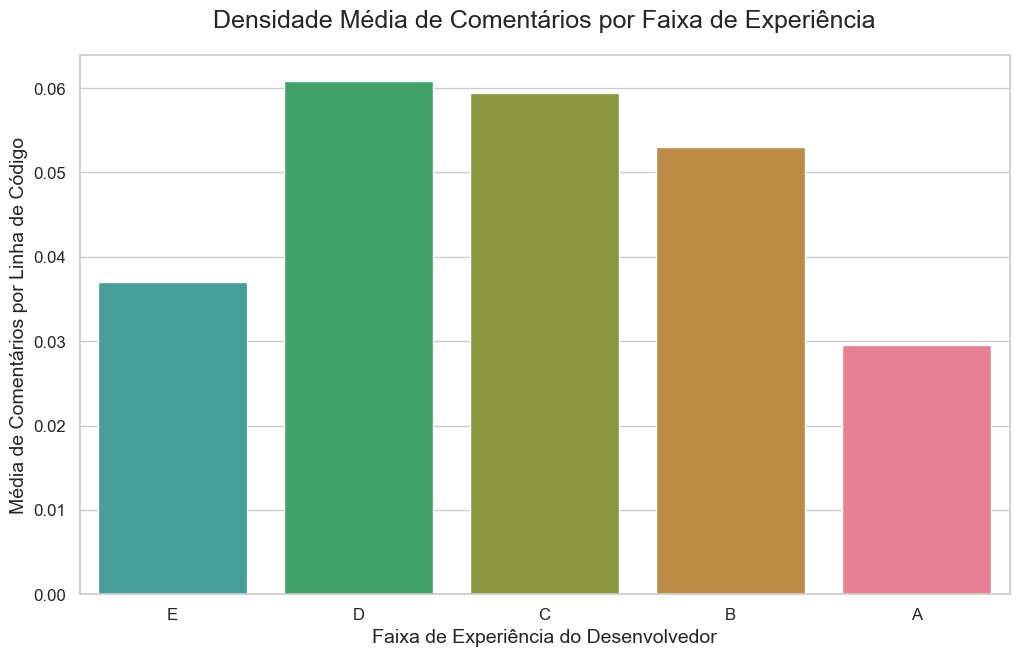

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- DEFINIÇÃO DA PALETA CONSISTENTE ---
# Colocamos a definição aqui para que a célula seja autossuficiente.
ordem_faixas_original = ['A', 'B', 'C', 'D', 'E']
cores_husl = sns.color_palette("husl", 8)
faixas_originais = ['A', 'B', 'C', 'D', 'E']
paleta_consistente = dict(zip(faixas_originais, cores_husl))
# ----------------------------------------

# Define o estilo global, mas sem a paleta, que será definida no próprio gráfico.
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(12, 7))

# Cria o gráfico de barras
barplot = sns.barplot(
    x=media_por_faixa.index,
    y=media_por_faixa['densidade_comentarios'],
    palette=paleta_consistente,  # <<< ALTERAÇÃO 1: Usa a paleta correta.
    order=['E', 'D', 'C', 'B', 'A']   # <<< ALTERAÇÃO 2: Garante a ordem das barras.
)

plt.title('Densidade Média de Comentários por Faixa de Experiência', fontsize=18, pad=20)
plt.xlabel('Faixa de Experiência do Desenvolvedor', fontsize=14)
plt.ylabel('Média de Comentários por Linha de Código', fontsize=14)
plt.show()

Gráfico de Dispersão

Carregar dados para ideia 5

Gerando um gráfico de box plot para mostrar a distribuição de comentários por tamanho de PR...


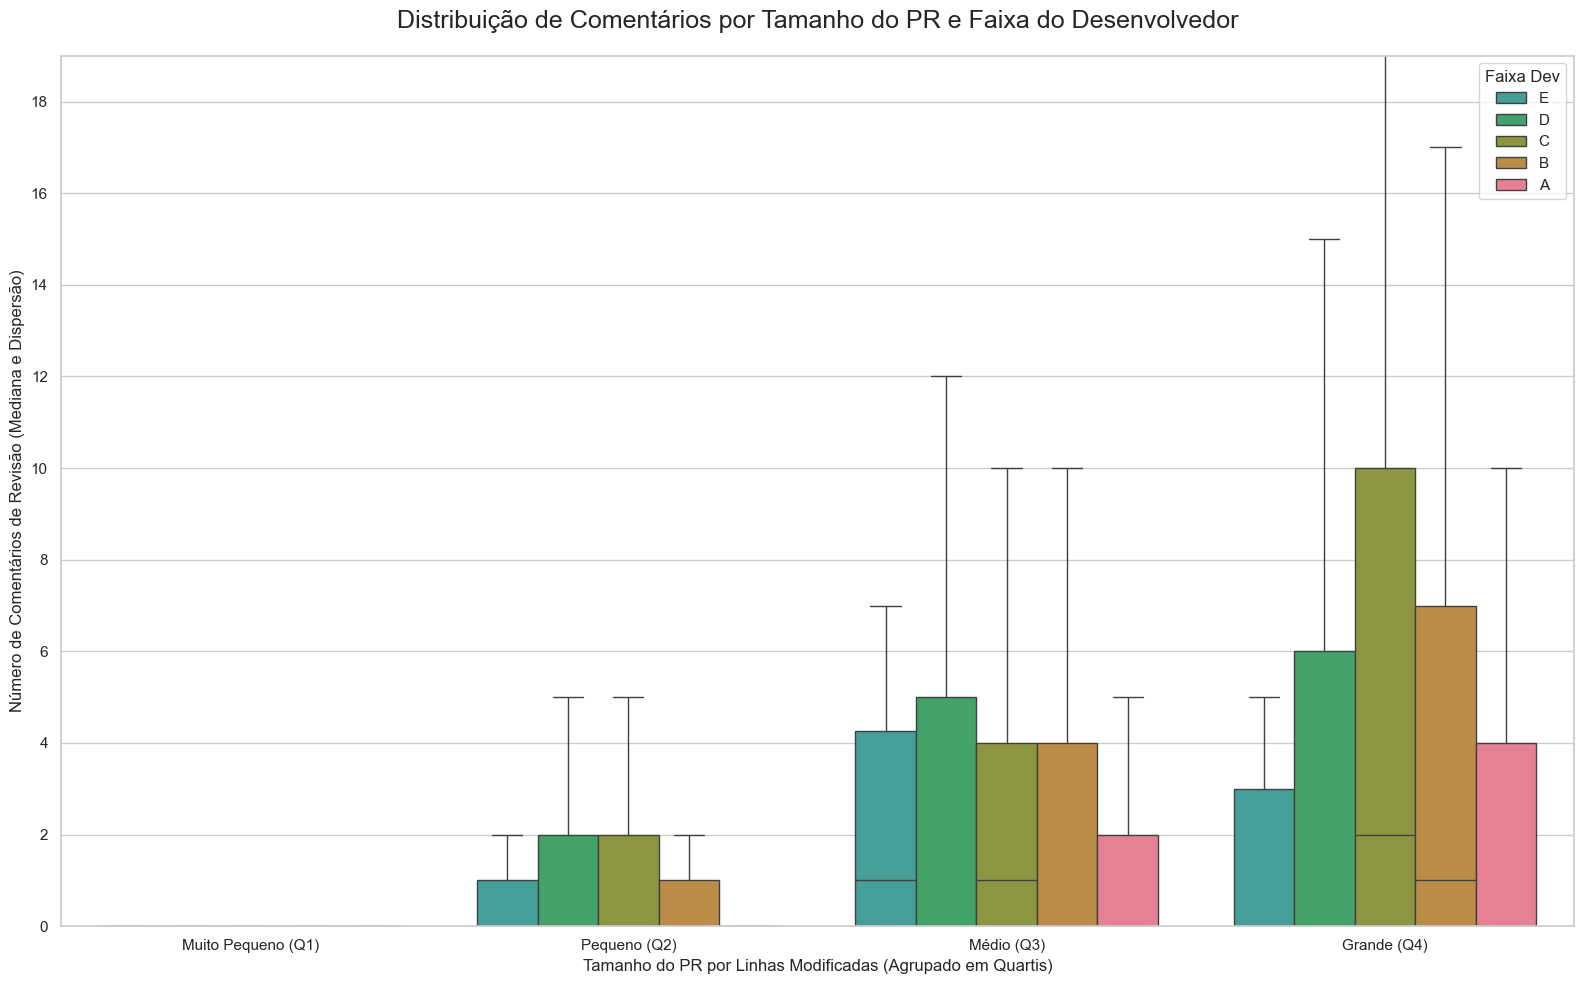

In [7]:
import numpy as np # Adicionado para usar np.arange
import matplotlib.pyplot as plt # Importação explícita para clareza
import seaborn as sns # Importação explícita para clareza
import pandas as pd # Importação explícita para clareza

# Célula 6: Box Plot Agrupado (Substituto para o Gráfico de Dispersão)

print("Gerando um gráfico de box plot para mostrar a distribuição de comentários por tamanho de PR...")

# 1. Criar faixas de tamanho para o PR
# (A lógica para criar os bins permanece a mesma)
try:
    df_qualidade['tamanho_pr_bin'] = pd.qcut(
        df_qualidade['tamanho_pr'],
        q=4,
        labels=['Muito Pequeno (Q1)', 'Pequeno (Q2)', 'Médio (Q3)', 'Grande (Q4)'],
        duplicates='drop'
    )
except ValueError as e:
    print(f"Aviso: Não foi possível criar bins dinâmicos, usando faixas fixas. Erro: {e}")
    bins_fixos = [0, 50, 200, 1000, float('inf')]
    labels_fixos = ['Muito Pequeno (0-50)', 'Pequeno (51-200)', 'Médio (201-1000)', 'Grande (1001+)']
    df_qualidade['tamanho_pr_bin'] = pd.cut(df_qualidade['tamanho_pr'], bins=bins_fixos, labels=labels_fixos, right=False)


# 2. Configurar e criar o gráfico
plt.figure(figsize=(16, 10))
sns.set_theme(style="whitegrid")

sns.boxplot(
    data=df_qualidade,
    x='tamanho_pr_bin',
    y='num_review_comments',
    hue='faixa',
    hue_order=['E', 'D', 'C', 'B', 'A'],
    palette=paleta_consistente,
    showfliers=False
)

# 3. Melhorar a legibilidade
plt.title('Distribuição de Comentários por Tamanho do PR e Faixa do Desenvolvedor', fontsize=18, pad=20)

# --- MODIFICAÇÃO 1: Deixar explícito que o tamanho é medido em linhas ---
plt.xlabel('Tamanho do PR por Linhas Modificadas (Agrupado em Quartis)', fontsize=12)
# --- FIM DA MODIFICAÇÃO 1 ---

plt.ylabel('Número de Comentários de Revisão (Mediana e Dispersão)', fontsize=12)

limite_y = df_qualidade['num_review_comments'].quantile(0.98)
limite_y_final = limite_y if limite_y > 0 else 10
plt.ylim(0, limite_y_final)

# --- MODIFICAÇÃO 2: Definir os ticks do eixo Y para serem inteiros, de 2 em 2 ---
# Criamos uma sequência de 0 até o limite superior, com passo de 2
ticks_y = np.arange(0, limite_y_final + 1, step=2)
plt.yticks(ticks_y)
# --- FIM DA MODIFICAÇÃO 2 ---

plt.legend(title='Faixa Dev')
plt.tight_layout()
plt.show()

In [8]:
# CÉLULA 1 (NO SEU NOVO NOTEBOOK)

# Célula de verificação no notebook ANTIGO

if 'lista_prs_enriquecida' in locals() and len(lista_prs_enriquecida) > 0:
    print(f"A variável 'lista_prs_enriquecida' existe e tem {len(lista_prs_enriquecida)} elementos.")
    print("Amostra do primeiro elemento:")
    # Mostra o primeiro PR para garantir que não está corrompido
    print(lista_prs_enriquecida[0])
else:
    print("ERRO: A variável 'lista_prs_enriquecida' está vazia ou não foi criada!")


A variável 'lista_prs_enriquecida' existe e tem 73325 elementos.
Amostra do primeiro elemento:
{'pr_number': 30749, 'repo': 'apache-superset', 'title': 'docs: Update INTHEWILD.md with Medic', 'author': '1yuv', 'state': 'closed', 'merged_at': '2024-10-30T01:29:33Z', 'created_at': '2024-10-30T01:04:34Z', 'head_sha': '158b796a7977ee8563670befaeb78da3ed83ec80', 'ci_status_on_head': 'pending', 'counts': {'files': 1, 'commits': 1, 'reviews': 2, 'review_comments': 0, 'issue_comments': 1, 'timeline_events': 9}, 'files': [{'filename': 'RESOURCES/INTHEWILD.md', 'additions': 1, 'deletions': 0}], 'commits': [{'sha': '158b796a7977ee8563670befaeb78da3ed83ec80', 'message': 'docs: Update INTHEWILD.md with Medic'}], 'reviews': [{'user': 'github-actions[bot]', 'state': 'COMMENTED', 'submitted_at': '2024-10-30T01:07:50Z', 'body': 'Congrats on making your first PR and thank you for contributing to Superset! :tada: :heart:\n\nWe hope to see you in our [Slack](https://apache-superset.slack.com/) community t

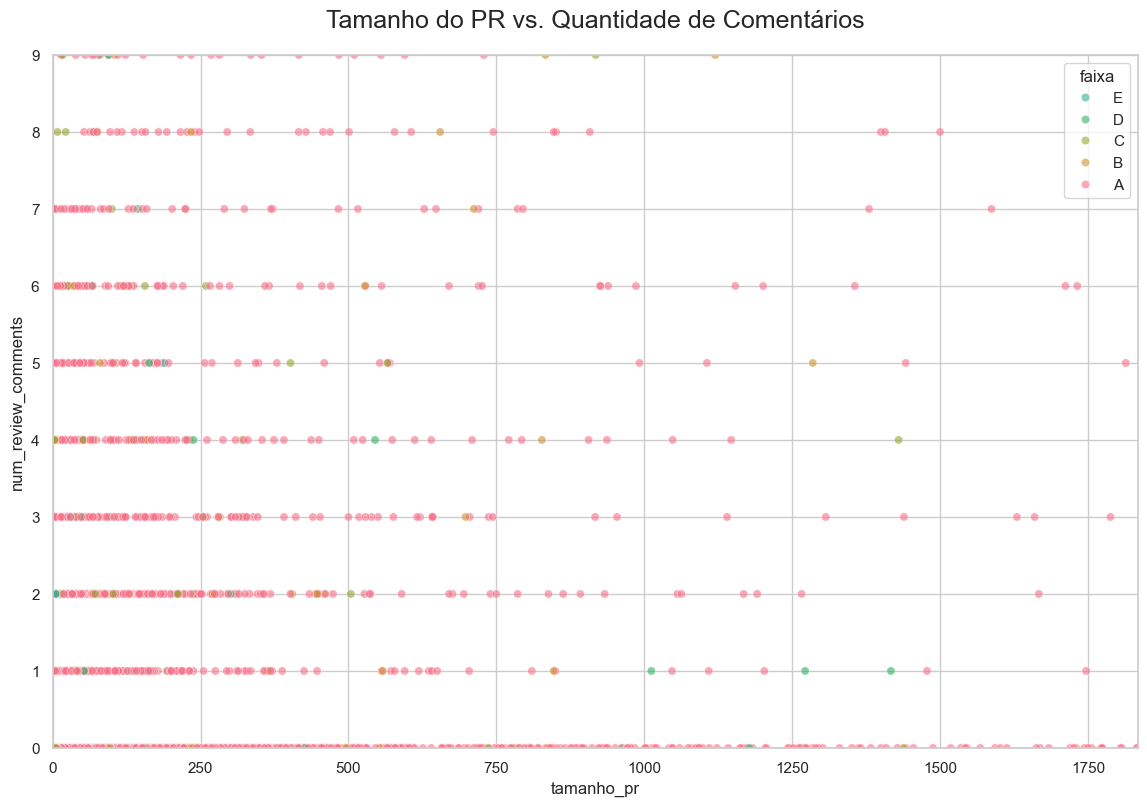

In [9]:
# Célula 6: Gráfico de Dispersão

plt.figure(figsize=(14, 9))

# Usar uma amostra para evitar overplotting e lentidão
amostra_df = df_qualidade.sample(n=min(len(df_qualidade), 5000), random_state=42)

scatterplot = sns.scatterplot(
    data=amostra_df,
    x='tamanho_pr',
    y='num_review_comments',
    hue='faixa',
    hue_order=['E', 'D', 'C', 'B', 'A'],
    palette=paleta_consistente,
    alpha=0.6
)
plt.title('Tamanho do PR vs. Quantidade de Comentários', fontsize=18, pad=20)
plt.xlim(0, amostra_df['tamanho_pr'].quantile(0.95))
plt.ylim(0, amostra_df['num_review_comments'].quantile(0.95))
plt.show()

Conclusão Principal:

Sua análise confirma a hipótese central: a qualidade do código submetido, medida pela densidade de feedback recebido, aumenta significativamente com a experiência do desenvolvedor. No entanto, a jornada não é linear e revela um "pico de complexidade" para desenvolvedores intermediários.


1. A Tabela de Métricas (media_por_faixa)
Esta tabela é o coração quantitativo da sua análise.

num_review_comments (Número Médio de Comentários):

A relação não é uma simples queda. Ela começa baixa na Faixa E (0.98), atinge um pico na Faixa C (3.23) e depois começa a cair até a Faixa A (1.81).
Interpretação: Desenvolvedores da Faixa E provavelmente fazem PRs tão pequenos e simples que não geram muita discussão. Os desenvolvedores intermediários (D e C) estão no "olho do furacão": eles já têm confiança para pegar tarefas complexas que geram muita discussão, mas ainda não têm a maestria dos especialistas para submeter um código limpo de primeira. Os especialistas (A) fazem código complexo, mas com tanta qualidade que a quantidade de comentários necessários diminui.
densidade_comentarios (Qualidade por Linha de Código):

Esta é a sua métrica mais importante. Ela também mostra uma curva, com o pico de "problemas por linha de código" na Faixa D (0.0608).
Interpretação: Isso reforça a história acima. Normalizado pelo tamanho, o código dos desenvolvedores da Faixa D é o que gera mais atrito na revisão. Eles são os que mais "sofrem" para adequar seu código aos padrões de qualidade. A Faixa A tem uma densidade menos da metade da Faixa D (0.0296 vs 0.0608), uma diferença brutal que comprova sua senioridade.
proporcao_changes_requested (Proporção de "Manda de Volta"):

Aqui a tendência é claríssima e linear: quanto menos experiente, maior a chance de ter o PR bloqueado. A Faixa E tem 6.4% de chance, enquanto a Faixa A tem apenas 1.6%.
Interpretação: Este é um indicador direto de qualidade e adequação. Desenvolvedores especialistas submetem código que está muito mais próximo do "aceitável" do que os novatos.
rework_commits (Commits de Retrabalho):

O resultado de 0.0 para todas as faixas é um achado importante por si só. Isso sugere que a métrica como foi definida não capturou retrabalho, ou que o processo de desenvolvimento nesses repositórios é diferente.
Hipóteses para o 0.0:
Problema nos Dados: Os dados de timestamp dos commits não estavam disponíveis ou no formato esperado.

Prática de Desenvolvimento: Os desenvolvedores podem usar git commit --amend e git push --force para corrigir seus PRs. Isso altera o commit existente em vez de adicionar um novo, então nossa métrica não detectaria. Esta é uma prática comum.
Outra Forma de Retrabalho: O retrabalho pode acontecer em um PR subsequente, não no mesmo.

2. Gráfico: Densidade Média de Comentários
Este gráfico visualiza perfeitamente a sua descoberta mais interessante.

A Curva do Aprendizado: O gráfico não é uma rampa, é uma colina. Isso sugere que a jornada do desenvolvedor passa por um "vale da qualidade" (o pico da densidade de comentários nas faixas D e C) antes de atingir a maestria.

A História:

Faixa E: "Estou fazendo mudanças pequenas e seguras."
Faixa D/C: "Estou tentando fazer coisas grandes e complexas, mas estou cometendo muitos erros por linha de código."
Faixa A/B: "Eu faço coisas grandes e complexas, mas com muito mais qualidade e menos erros."

3. Gráfico: Tamanho do PR vs. Quantidade de Comentários
Este gráfico de dispersão adiciona a última camada de contexto.

Faixa E (Verde Claro): Os pontos estão concentrados no canto inferior esquerdo. Isso confirma visualmente que eles fazem PRs pequenos que recebem poucos comentários.
Faixa A (Roxo Escuro): Os pontos estão espalhados por todo o eixo de "Tamanho do PR", mas tendem a se manter na parte de baixo do eixo de "Número de Comentários". Isso prova que, independentemente do tamanho da tarefa, eles conseguem manter a qualidade alta. Para qualquer tamanho de PR, um desenvolvedor da Faixa A tende a receber menos comentários que os outros.

Linha de Base em Y=0: É notável a quantidade de PRs com 0 comentários de revisão em todas as faixas, indicando que muitas mudanças são triviais ou são aprovadas sem necessidade de discussão.

Conclusão Final: O Perfil de Cada Faixa
Com base em seus dados, podemos criar um "perfil" para cada faixa:

Faixa E - O Contribuinte Pontual: Faz contribuições pequenas e focadas. Seu código raramente é bloqueado, mas isso se deve mais à simplicidade da tarefa do que à habilidade técnica. Gera pouca discussão.

Faixa D e C - O Desenvolvedor em Ascensão: É a fase mais crítica. Estes desenvolvedores já têm autonomia para pegar tarefas complexas, mas ainda estão aprendendo a lidar com a qualidade exigida. Seu código gera a maior densidade de discussões e erros por linha. É o grupo que mais precisa de mentoria e revisões detalhadas.

Faixa B - O Profissional Sênior: Já passou pelo "vale da qualidade". Consegue entregar trabalho complexo com uma densidade de comentários significativamente menor, mostrando maturidade e domínio técnico.

Faixa A - O Multiplicador de Qualidade: É a referência. Entrega código de altíssima qualidade, independentemente do tamanho do desafio. Seus PRs raramente são bloqueados e servem como exemplo para os demais. Eles não apenas produzem, mas elevam o padrão de qualidade do projeto.